# Generic script for processing machine learning

In [1]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.stats import randint, uniform

import matplotlib.pyplot as plt

### Note:

You will need to change the kernel to ml_env to use `mlxtend`

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [4]:
PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/"

In [5]:
DEMAND_FILE = "daily_demand_2010-2020_stl.nc"

In [6]:
MARKET = "NEM" # "NEM" or "EU"

In [7]:
REGION = "NSW"

In [8]:
REMOVE_WEEKEND = True

In [9]:
REMOVE_XMAS = True

In [10]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [11]:
MASK_NAME = "pop_dens_mask"

In [12]:
TIME_COLUMNS = ["is_weekend"]

# Alternatives:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
# time_cols = ["is_weekend", "is_transition"]
# time_cols = []

In [13]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2011

In [14]:
FIRST_TEST_YEAR = 2012
LAST_TEST_YEAR = 2012

In [15]:
N_FEATURES = "parsimonious"

In [16]:
T_ONLY = False

In [17]:
CALENDAR = fn.get_calendar("AU", "AU-" + REGION)

### Prepare demand data

In [29]:
dem_da = xr.open_dataset(PATH + "data/energy_demand/" + DEMAND_FILE)["demand_stl"]

In [30]:
dem_da = fn.remove_time(dem_da, REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, calendar=CALENDAR)

In [31]:
dem_da = dem_da.sel(region=REGION).expand_dims({"region": [REGION]})

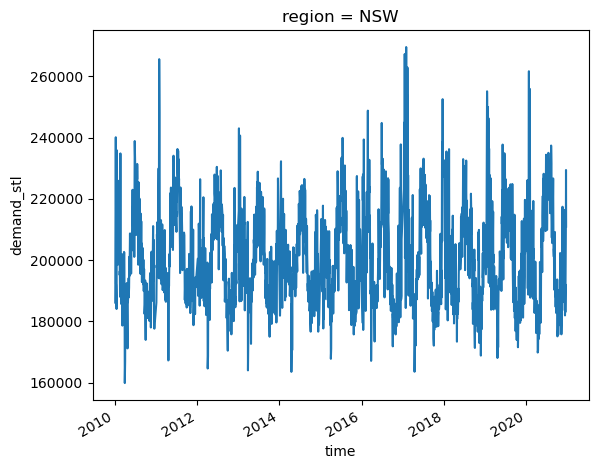

In [23]:
dem_da.plot()

### Prepare predictors

In [21]:
files = fn.get_predictor_files(MARKET, MASK_NAME)
files

['/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/hdd_18_rollmean4_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2t_rollmean3_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/rh_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2t_rollmean4_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2tmin_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/cdd_24_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/10w_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/hdd_18_rollmean3_era5_daily_1959-2022_NEM_pop_d

In [22]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [23]:
pred_ds = pred_ds.sel(region=REGION).expand_dims({"region": [REGION]}).compute()

In [24]:
pred_ds = fn.remove_time(pred_ds, REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, calendar=CALENDAR)

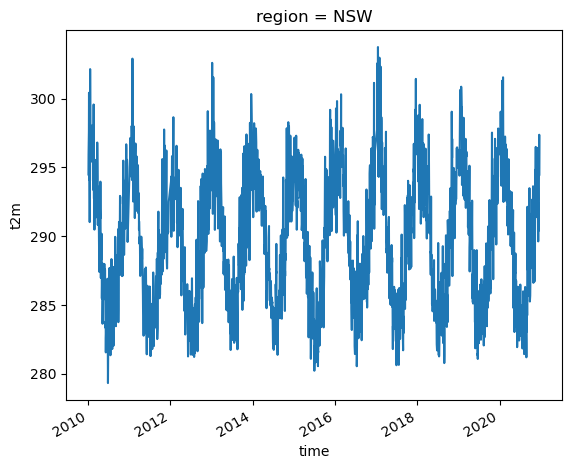

In [26]:
pred_ds.t2m.sel(time=slice("2010", "2020")).plot()

## Prepare dataframe for machine learning

In [27]:
T_ONLY = True

In [32]:
region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    
    for t in TIME_COLUMNS:
        df = fn.add_time_column(df, t)
        
    if T_ONLY:
        new_cols = np.append(np.append("demand", TIME_COLUMNS), ["mtpr", "w10", "msdwswrf", "rh", "q", "t2m"])
    else:
        new_cols = np.append(np.append("demand", TIME_COLUMNS), df.columns[:-(len(TIME_COLUMNS) + 1)])
    df = df[new_cols]
    
    region_dfs[region] = df

In [47]:
# region_dfs[region]["year"] = region_dfs[region].index.year

In [48]:
region_dfs[region].head()

,demand,is_weekend,mtpr,w10,msdwswrf,rh,q,t2m
2010-01-07,186114.710269,0,1.220994e-05,2.670003,220.577600,71.384486,11.394804,294.489710
2010-01-08,191585.533913,0,5.714371e-06,2.344185,283.436342,70.648160,12.254509,295.949524
2010-01-11,215503.167509,0,3.184828e-07,3.247642,308.849279,70.372027,13.343314,297.628731
2010-01-12,240091.354585,0,2.931551e-06,2.469718,338.232604,61.566510,14.070295,300.434798
2010-01-13,204167.493766,0,2.063133e-05,4.408566,284.872303,73.892375,12.213959,294.904393


### Subselect predictors if desired

In [33]:
region_dfs[REGION] = region_dfs[REGION][
    ["demand", "mtpr", "w10", "msdwswrf", "rh", "q", "t2m"]
]

In [34]:
# region_dfs[region].head()

## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out a consecutive block for testing (not random non-consecutive times).

In [35]:
test_len = dem_da.sel(time=slice(str(FIRST_TEST_YEAR), str(LAST_TEST_YEAR))).time.values.shape[0]

In [38]:
FIRST_TEST_YEAR

2020

In [39]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(region_dfs[REGION], FIRST_TRAIN_YEAR, LAST_TEST_YEAR),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [40]:
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(2488, 3) (249, 3) (2488,) (249,)


## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [62]:
rf = ExtraTreesRegressor(
    random_state=0
)

In [63]:
logo = fn.leave_one_group_out(
    train_X,
    train_y,
    dem_da.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))),
    str(FIRST_TRAIN_YEAR),
    str(LAST_TRAIN_YEAR),
)

In [64]:
%%time
model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error", k_features=N_FEATURES)

CPU times: user 1.12 s, sys: 10.4 ms, total: 1.13 s
Wall time: 1.13 s


In [65]:
model.subsets_

{1: {'feature_idx': (2,),
  'cv_scores': array([-11984.13550535, -12523.15960258]),
  'avg_score': -12253.64755396497,
  'feature_names': ('2',)},
 2: {'feature_idx': (0, 2),
  'cv_scores': array([-11211.65918594, -11763.8079314 ]),
  'avg_score': -11487.733558672324,
  'feature_names': ('0', '2')},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([-10869.06115419, -17574.97478941]),
  'avg_score': -14222.017971799654,
  'feature_names': ('0', '1', '2')}}

In [66]:
model.k_feature_idx_

(0, 2)

In [67]:
features = region_dfs[region].columns[1:]
features

Index(['hdd', 'cdd', 't2m'], dtype='object')

In [68]:
selected_features = list(features[list(model.k_feature_idx_)])
print(selected_features)

['hdd', 't2m']


In [69]:
results_df = pd.DataFrame.from_dict(model.get_metric_dict()).T

In [70]:
feature_names = [
    [features[i] for i in results_df["feature_idx"].iloc[j]]
    for j in range(len(results_df))
]

In [71]:
results_df["feature_names"] = feature_names

Add boolean column , with True in row of selected features

In [88]:
results_df["selected_features"] = [len(i) == len(selected_features) for i in results_df["feature_idx"]]

In [89]:
results_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,selected_features
1,"(2,)","[-11984.135505352799, -12523.159602577138]",-12253.647554,[t2m],1159.616752,269.512049,269.512049,False
2,"(0, 2)","[-11211.659185941115, -11763.807931403535]",-11487.733559,"[hdd, t2m]",1187.852153,276.074373,276.074373,True
3,"(0, 1, 2)","[-10869.061154186098, -17574.97478941321]",-14222.017972,"[hdd, cdd, t2m]",14426.608805,3352.956818,3352.956818,False


Write results to file

In [178]:
def get_filename(
    filename, market, region, mask_name,
    first_train_year, last_train_year, first_test_year, last_test_year,
    weekend=False, xmas=False, month=None
):
    """
    Return a filename appropriate for the modelling choices made.
    """
    filename = filename + "_" + market + "_" + region + "_" + mask_name
    if weekend:
        filename += "_NOWEEKEND"
    if xmas:
        filename += "_NOXMAS"
    if month is not None:
        filename = filename + "_NOMONTH" + str(month)
        
    filename =  filename + "_training" + str(first_train_year) + "-" + str(last_train_year)
    filename = filename + "_test" + str(first_test_year) + "-" + str(last_test_year)
    
    return filename

In [180]:
filename = get_filename(
    "feature_selection_results", MARKET, REGION, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH
)

In [181]:
filename

'feature_selection_results_NEM_NSW_pop_dens_mask_training2010-2011_test2012-2012'

In [182]:
results_df.to_csv(
    PATH + "model_results/feature_selection/random_forest/" + filename + ".csv",
)

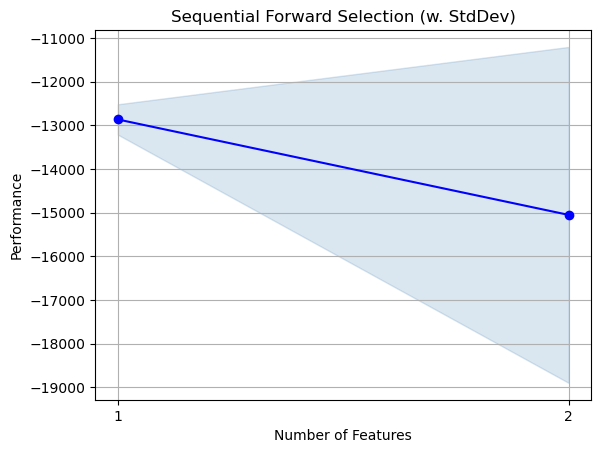

In [114]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [133]:
# parameters = {
#     "n_estimators": randint(200, 500), # no. trees in the forest
#     "min_samples_leaf": randint(5, 30), # min no. samples at leaf node
#     "max_depth" : randint(5, 50), # max depth of each tree
#     "max_leaf_nodes": randint(20, 200) # size of tree, how many end nodes
# }

In [185]:
# very restricted space for testing
parameters = {
    "n_estimators": randint(20, 22), # no. trees in the forest
    "min_samples_leaf": randint(5, 7), # min no. samples at leaf node
    "max_depth" : randint(5, 7), # max depth of each tree
    "max_leaf_nodes": randint(20, 22) # size of tree, how many end nodes
}

In [186]:
retain = ["demand"] + selected_features

In [187]:
final_features = region_dfs[region][retain]

In [188]:
final_features.head()

,demand,hdd
2010-01-01,167621.888019,0.000324
2010-01-02,169699.603911,0.008797
2010-01-03,162531.991928,0.236494
2010-01-04,180512.667072,0.019122
2010-01-05,194817.439344,-0.000134


In [189]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(final_features, FIRST_TRAIN_YEAR, LAST_TEST_YEAR),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [190]:
rf = ExtraTreesRegressor()

In [191]:
logo = fn.leave_one_group_out(
    train_X,
    train_y,
    dem_da.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))),
    str(FIRST_TRAIN_YEAR),
    str(LAST_TRAIN_YEAR)
)

[2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010
 2010 

In [192]:
%%time
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=3#200
)

CPU times: user 120 ms, sys: 13.9 ms, total: 134 ms
Wall time: 172 ms


In [193]:
best_params

{'max_depth': 6,
 'max_leaf_nodes': 21,
 'min_samples_leaf': 6,
 'n_estimators': 21}

In [194]:
list(best_params.keys())

['max_depth', 'max_leaf_nodes', 'min_samples_leaf', 'n_estimators']

In [195]:
best_params_df = pd.Series(
    [best_params[i] for i in list(best_params.keys())],
    index=list(best_params.keys())
)

In [196]:
best_params_df

max_depth            6
max_leaf_nodes      21
min_samples_leaf     6
n_estimators        21
dtype: int64

In [197]:
filename = get_filename(
    "hyperparameters", MARKET, REGION, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH
)

In [198]:
best_params_df.to_csv(
    PATH + "model_results/hyperparameters/random_forest/" + filename + ".csv",
)

## Finalise model

In [199]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [200]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [201]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [202]:
pred_train.shape

(730,)

In [203]:
pred_test.shape

(366,)

#### Dataframes of observations and predictions for training and testing period

Training

In [219]:
train_df = pd.DataFrame(
    np.vstack([train_y, pred_train]).transpose(),
    columns=["observation", "prediction"],
    index=dem_da.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))).time
)

In [220]:
train_df

,observation,prediction
2010-01-01,167621.888019,199368.696176
2010-01-02,169699.603911,196443.651461
2010-01-03,162531.991928,188464.388320
2010-01-04,180512.667072,193922.764594
2010-01-05,194817.439344,200226.879254
...,...,...
2011-12-27,163309.141429,187309.335707
2011-12-28,170383.365991,188070.772650
2011-12-29,171176.454211,188070.772650
2011-12-30,170610.961444,188037.752945


In [221]:
filename = get_filename(
    "training_predictions", MARKET, REGION, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH
)

In [222]:
best_params_df.to_csv(
    PATH + "model_results/training/random_forest/" + filename + ".csv",
)

Test

In [223]:
test_df = pd.DataFrame(
    np.vstack([test_y, pred_test]).transpose(),
    columns=["observation", "prediction"],
    index=dem_da.sel(time=slice(str(FIRST_TEST_YEAR), str(LAST_TEST_YEAR))).time
)

In [225]:
filename = get_filename(
    "test_predictions", MARKET, REGION, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH
)

In [226]:
best_params_df.to_csv(
    PATH + "model_results/test/random_forest/" + filename + ".csv",
)